# Libraries

In [1]:
import numpy as np
import pandas as pd 
import argparse
import math
import os
import re
import uuid
from joblib import load
from Levenshtein import distance
import pickle
import json
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

# Important Paths to import

In [2]:
dd03l_path = 'D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD03L.csv'
# Specify the path to the folder containing CSV files of tables to extract activities
csv_folder_path = r'D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\WM_final'
# path to pkl file with datatypes encoded as integers
datatype_encoding_path =  r'D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\code\InProgress\ML Model\datatype_encoding_mapping.pkl'
# path to weights of the gmm model
gmm_model_weights_path = r'D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\code\InProgress\ML Model\gmm_model.pkl'

# Input

In [3]:
input_table_list = []
input_table_list = ['LTBK','LTBP','LTAK','LTAP','LINV','LQUA']
# input_table_list = ['EKKO' , 'EKPO' , 'EBAN' ,'EBKN','RBKP', 'RSEG' ,'BKPF','BSEG','CDHDR','CDPOS','EKBE']#'MKPF','BKPF']
#  input_table_list = ['EKKO', 'EBAN', 'EKPO' , 'VBFA']
# input_table_list = ['EKKO', 'EKBE']

In [4]:
def import_dd03l(input_table_list):
    
    dd03l_ = pd.read_csv( dd03l_path , encoding= 'unicode_escape', low_memory= False )
    
    tabnames_list = input_table_list

# Filter the dd03l DataFrame based on the tabnames_list
    dd03l = dd03l_[dd03l_['TABNAME'].isin(tabnames_list)]
    del dd03l_
    return dd03l
dd03l = import_dd03l(input_table_list)
dd07t = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD07T.csv'  , encoding= 'unicode_escape' )
tstct = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\TSTCT_E.csv', encoding= 'unicode_escape')
dd03t = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD03T_E.csv', encoding= 'unicode_escape')
dd02v = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD02V.csv', encoding= 'unicode_escape')
tcdob = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\TCDOB.csv', encoding= 'unicode_escape')
tcdobt= pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\TCDOBT.csv', encoding= 'unicode_escape')
t003t = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\T003T.csv', encoding= 'unicode_escape')

# ML model

In [5]:
class MachineLearning:
    
    def __init__(self, num_rows=1000):
        self.num_rows = num_rows
        
    def get_col_datatyp_permissible_length_position_dictionary(self, tabname_str, tab_df, dd03l):
        """
        Creates a dictionary with the datatype, permissible length, and position number for each column in the table.

        Args:
            tabname_str (str): Name of the SAP table.
            tab_df (pandas.DataFrame): DataFrame of the SAP table.
            dd03l (pandas.DataFrame): DataFrame containing metadata information.

        Returns:
            datatype_permissible_len_dict (dict): Dictionary with column name as key and [datatype, permissible len, position number] as value.
        """
        tabname_str = tabname_str.upper()
        datatype_permissible_len_dict = {}

        for col in tab_df.columns:
            col = col.upper()
            col_exists = dd03l['FIELDNAME'].eq(col).any()

            if col_exists:
                try:
                    datatype = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'DATATYPE'].iloc[0]
                    max_len = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'LENG'].iloc[0]
                    col_position = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'POSITION'].iloc[0]
                    datatype_permissible_len_dict[col] = [datatype, max_len, col_position]
                    
                except:
                    datatype = "Datatype not found"
                    max_len = "0" #using 0 to avoid code breaking
                    col_position = '50' #using 50, since higher the num lower the priority
                    datatype_permissible_len_dict[col] = [datatype, max_len, col_position]
                
        return datatype_permissible_len_dict
    
    def uniqueness_score(self, column):
        unique_values = column.unique()
        total_values = len(column)
        uniqueness_score = len(unique_values) / total_values
        return uniqueness_score

    def calculate_uniqueness_scores(self, df):
        num_rows = len(df)
        # num_groups = int(np.ceil(num_rows / 1000))
        subset_size = 1000 if num_rows > 1000 else num_rows
        num_groups = int(np.ceil(num_rows / subset_size))
        groups = np.array_split(df.sample(frac=1), num_groups)
        uniqueness_df = pd.DataFrame(columns=df.columns)

        for group in groups:
            group_scores = []
            for col in df.columns:
                score = self.uniqueness_score(group[col])
                group_scores.append(score)
            uniqueness_df = uniqueness_df.append(pd.Series(group_scores, index=df.columns), ignore_index=True)

        return uniqueness_df

    def calculate_duplicate_metric(self, uniqueness_df):
        duplicate_df = 1 - uniqueness_df
        return duplicate_df

    def calculate_richness_score(self, duplicate_metric_df):
        richness_df = 1 / duplicate_metric_df
        richness_df = richness_df.replace([np.inf, -np.inf], 10000) # replace inf values with a large number
        return richness_df

    def similarity_score(self, column):
        distinct_values = column.unique()
        num_distinct = len(distinct_values)
        similarity_scores = []

        if num_distinct <= 1:
            return 0.0  # Return 0 for columns with only one unique value

        for i in range(num_distinct):
            for j in range(i + 1, num_distinct):
                distance_normalized = distance(str(distinct_values[i]), str(distinct_values[j])) / max(len(str(distinct_values[i])), len(str(distinct_values[j])))
                similarity_scores.append(1 - distance_normalized)

        return np.min(similarity_scores)  # Compute the average similarity score

    def calculate_similarity_scores(self, df):
        num_rows = len(df)
        # num_groups = int(np.ceil(num_rows / 1000))
        subset_size = 1000 if num_rows > 1000 else num_rows
        num_groups = int(np.ceil(num_rows / subset_size))
        groups = np.array_split(df.sample(frac=1), num_groups)
        similarity_scores_list = []

        for group in groups:
               group_scores = []
               for col in df.columns:
                   score = self.similarity_score(group[col])
                   group_scores.append(score)
               similarity_scores_list.append(group_scores)

        # similarity_df = pd.DataFrame(similarity_scores_list, columns=[f"{col}_similarity" for col in df.columns])
        similarity_df = pd.DataFrame(similarity_scores_list, columns=[col for col in df.columns])
        similarity_df = similarity_df.replace([np.nan, -np.nan], 0)
        similarity_df = similarity_df.replace([np.inf, -np.inf], 10000)
        return similarity_df

    def missing_value_ratio(self, df):
        """
        Computes the ratio of missing values in subsets of 1000 random rows for each column of the given DataFrame

        Args:
            df (pandas.DataFrame): Input DataFrame

        Returns:
            pandas.DataFrame: A DataFrame containing the missing value ratio for each column
        """
        missing_values = [np.nan, None, " ", 0]  # Define the set of missing values
        # subset_size = 1000  # Define the size of each subset
        num_rows = len(df)
        subset_size = 1000 if num_rows > 1000 else num_rows
        # Compute the number of subsets needed for each column
        num_subsets = (df.shape[0] + subset_size - 1) // subset_size

        # Initialize an empty DataFrame to store the results
        missing_value_df = pd.DataFrame(columns=df.columns)

        # Compute the missing value ratio for each subset of 1000 rows for each column
        for i in range(num_subsets):
            start = i * subset_size
            end = min((i + 1) * subset_size, df.shape[0])
            subset = df.iloc[start:end]
            missing_count = subset.apply(lambda x: x.isin(missing_values).sum())
            missing_ratio = missing_count / subset_size
            missing_value_df.loc[i] = missing_ratio

        return missing_value_df

    def calculate_formatting_constraints(self, missing_value_df):
        formatting_constraints_df = 1 - missing_value_df
        return formatting_constraints_df

    def entropy_formula(self, column):
        counts = column.value_counts(normalize=True)
        entropy = 0
        for count in counts:
            entropy -= count * math.log(count, 2)
        return entropy

    def calculate_entropy(self, df):
        if isinstance(df, pd.Series):
            df = pd.DataFrame(df)
        num_rows = len(df)
        subset_size = 1000 if num_rows > 1000 else num_rows
        entropy_scores = {}  # dictionary to store entropy scores for each column

        for column in df.columns:
            entropy_scores[column] = []  # initialize list for column's entropy scores
            # for i in range(math.ceil(len(df) / 1000)):  # loop through subsets of 1000 random rows
            for i in range(math.ceil(num_rows / subset_size)):
                subset = df[column].sample(n=subset_size)
                # subset = df[column].sample(n=1000)  # select 1000 random rows for the column
                entropy = self.entropy_formula(subset)
                entropy_scores[column].append(entropy)

        entropy_df = pd.DataFrame.from_dict(entropy_scores)
        return entropy_df

    def combine_metrics(self, dataTyp_len_position, uniqueness_df, duplicate_metrics_df,
                            calculate_richness_df, similarity_score_df, missing_value_df,
                            formatting_constraints_df, entropy_df, tab_name_str, table_df):
        # initialize an empty DataFrame to store the results
        tab_name_str = tab_name_str.upper()
        result_df = pd.DataFrame(columns=['table_name', 'col_name',
                                          'uniqueness_scores', 'duplicate_values', 'richness',
                                          'similarity_score', 'missing_ratio', 'formatting_constraints',
                                          'entropy', 'time_precision', 'value_ambiguity', 'position',
                                          'permissible_len', 'datatype'])
        dataTyp_len_position_dict = dataTyp_len_position
        # iterate over the columns and fill the result_df
        for col_name in table_df.columns:
            # get the values for the current column from each input DataFrame
            unique_vals = uniqueness_df[col_name]
            duplicate_values = duplicate_metrics_df[col_name]
            richness = calculate_richness_df[col_name]
            similarity_score = similarity_score_df[col_name]
            miss_vals = missing_value_df[col_name]
            formatting_constraints = formatting_constraints_df[col_name]
            ent_vals = entropy_df[col_name]

            # Extract information from dataTyp_len_position_dict for the current column
            col_info = dataTyp_len_position_dict.get(col_name, [None, None, None])
            data_type, permissible_len, position = col_info

            # Determine time_precision and value_ambiguity based on conditions
            time_precision = 1 if data_type in ['DATS', 'TIMS'] else 0
            value_ambiguity = 1 if col_name == 'tcode' else 0

            # combine the values into a single Series
            combined_vals  = pd.DataFrame({ 'table_name': tab_name_str,
                                            'col_name': col_name,
                                            'uniqueness_scores': unique_vals,
                                            'duplicate_values': duplicate_values,
                                            'richness': richness,
                                            'similarity_score': similarity_score,
                                            'missing_ratio': miss_vals,
                                            'formatting_constraints': formatting_constraints,
                                            'entropy': ent_vals,
                                            'time_precision': time_precision,
                                            'value_ambiguity': value_ambiguity,
                                            'position': position,
                                            'permissible_len': permissible_len,
                                            'datatype': data_type
                                            })
            result_df = pd.concat([result_df , combined_vals])

        # generate the list of target values
        # targets = [select_conditions[col_names.index(col_name)] for col_name in result_df['col_name']]

        # assign the list to a new column in result_df
        # result_df['targets'] = targets
        return result_df

    def compute_metrics(self, tab_name_str, table_df, dd03l):
        # calculate the individual metrics first
        dataTyp_len_position = self.get_col_datatyp_permissible_length_position_dictionary(tab_name_str, table_df, dd03l)
        uniqueness_df = self.calculate_uniqueness_scores(table_df)
        duplicate_metrics_df = self.calculate_duplicate_metric(uniqueness_df)
        calculate_richness_df = self.calculate_richness_score(duplicate_metrics_df)
        similarity_score_df = self.calculate_similarity_scores(table_df)
        missing_value_df = self.missing_value_ratio(table_df)
        formatting_constraints_df = self.calculate_formatting_constraints(missing_value_df)
        entropy_df = self.calculate_entropy(table_df)

        # combine all the metrics to compute the training df
        result_df = self.combine_metrics(dataTyp_len_position, uniqueness_df, duplicate_metrics_df,
                                calculate_richness_df, similarity_score_df, missing_value_df,
                                formatting_constraints_df, entropy_df, tab_name_str, table_df)
        return result_df
    
    def compute_features(self , result):
        weights = {
        'Completeness': {'uniqueness_scores': 0.5, 'missing_ratio': 0.5},
        'Precision':    {'permissible_len': 0.33 , 'missing_ratio': 0.33 , 'time_precision': 0.33  },  
        'Integrity':    {'duplicate_values': 0.5,'formatting_constraints': 0.5 }, 
        'Objectivity':  {'uniqueness_scores': 0.5 , 'entropy':0.5 },  
        'Conciseness':  {'similarity_score': 0.5 , 'value_ambiguity':0.5 },    
        'Uniqueness':   {'uniqueness_scores': 0.7 ,'duplicate_values': 0.1,'richness':0.1,'similarity_score': 0.1 },
        'Informativeness': {'entropy':0.2 , 'position':0.2 ,'richness':0.2 ,'time_precision':0.2,'value_ambiguity':0.2 }  
        }

        # Initialize an empty DataFrame to store the calculated features
        output_df = pd.DataFrame(columns= list(weights.keys()))
        output_df[['table_name', 'col_name', 'datatype']] = result[['table_name', 'col_name', 'datatype']]
        # Initialize empty lists to store table_name, col_name, and datatype

        # Calculate features for each metric
        for feature, metrics in weights.items():
            feature_values = []

            for index, row in result.iterrows():
                value = 0.0

                for metric, weight in metrics.items():
                    value += weight * row.get(metric, 0.0)

                feature_values.append(value)

            output_df[feature] = feature_values

        feature_df = output_df
        return feature_df

    def get_predictions(self , features_df):
        features_df_clusters = features_df.copy()
        train_data = features_df.copy()
        train_data = train_data.drop(['table_name', 'col_name'], axis=1)
        with open(datatype_encoding_path, 'rb') as f:
            datatype_encoding_mapping = pickle.load(f)
        # encode the datatype in train data with mapping from pkl
        train_data['EncodedDatatype'] = train_data['datatype'].map(datatype_encoding_mapping)
        train_data = train_data.drop(['datatype'] , axis =1)

        # Load the saved GMM model
        loaded_gmm = load(gmm_model_weights_path)
        cluster_assignments = loaded_gmm.predict(train_data)
        features_df_clusters['Cluster'] = cluster_assignments
        result_df = features_df_clusters.groupby(['table_name', 'col_name'])['Cluster'].apply(lambda x: x.value_counts().idxmax()).reset_index()
        del(train_data , loaded_gmm , datatype_encoding_mapping)

        return result_df


# Activity Extractor

In [6]:
def get_activity_col_predictions(input_tab_name_str , raw_input_table , dd03l ):
    """
    This function takes input as the raw SAP table. 
    Then passes this table through the compute_metrics function which is defined in the  computeTestMetrics() class
    compute_metrics function comutes the metrics for each column, whcih are then used for prediction of the functionality of the col
    Then the get Predictions function is applied to this df, which adds a prediction col with the corresponding importance for each col

    Args:
        raw_sap_table(padas df): Raw SAP table from which activities need to be defined
    
    Returns: 
        col_prediction_table(padas df): df with table_name , col_name and Cluster. Where Cluster = 3 is activity
    """
    ml = MachineLearning()
    input_tab_name_str = str(input_tab_name_str.lower())
    col_metrics_table = ml.compute_metrics(input_tab_name_str, raw_input_table , dd03l)
    col_features = ml.compute_features(col_metrics_table)
    col_prediction_table = ml.get_predictions(col_features)

    return col_prediction_table
    
def get_timestamp_from_user(timestamp_cols):
    """
    This function asks the user to select timestamps, from the selected cols with TIMS and DATS datatypes
    Args:
        timestamp_cols: List of cols selected based on datatype of col
    Returns: 
        timestamp_selection: Two cols which have been selected by user as date and time info respectively
    """
    # Ask user to select timestamp column(s)
    print(f"I found {len(timestamp_cols)} columns with timestamp information:")
    for i, col in enumerate(timestamp_cols):
        print(f"{i+1}. {col}")
    timestamp_selection = input("Which column(s) do you want to use as timestamp for your eventlog? (Enter numbers separated by commas)")
    timestamp_selection = [timestamp_cols[int(i)-1] for i in timestamp_selection.split(',')]
    return timestamp_selection

def get_timestamp_from_json_by_table_name( table_name:str):
    """
    This function extracts timestamp columns for a specific SAP table from a JSON file containing SAP table information.
    Args:
        json_file_path (str): Path to the JSON file containing SAP table information.
        table_name (str): Name of the SAP table for which timestamp columns should be retrieved.
    Returns:
        timestamp_selection (list): List of columns selected as timestamps for the specified table.
    """
    json_file_path = r"D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\code\InProgress\tables_data.json"
    # Read the JSON file
    with open(json_file_path, "r") as json_file:
        data = json.load(json_file)

    tables = data.get("tables", [])

    # Find the table by name
    table_info = next((t for t in tables if t["table_name"] == table_name), None)

    if table_info:
        timestamp_cols = table_info.get("timestamp_columns", [])
        return timestamp_cols
    else:
        print(f"Table '{table_name}' not found in the JSON data.")
        return []

def add_PredictedActivityColumns_to_Default(col_prediction_table):
    """
    Adding the additional activity cols from predictions to the list of default columns selected.
    Columns with value 1 are useful to generate activities 
    NOTE: This will not create duplicates

    Args:
        col_prediction_table(df): The df with the predictions for columns of raw table
        activity_cols_default: List of the default columns which will be used to generate activities from a given table

    Returns:
        predicted_activity_col: List of all the columns from the raw table that will be used to create activities
    """    
    # all_activity_cols = []
    # print("Adding the additional activity columns from predictions to default selection")
    predicted_activity_col = col_prediction_table[ (col_prediction_table["Cluster"] == 3)]["col_name"].tolist()
    # for col in predicted_activity_col:
    #     if col not in all_activity_cols:
    #         all_activity_cols.append(col)
    print("Columns predicted to make activities are:" , predicted_activity_col)
    return predicted_activity_col

def get_col_datatyp_dictionary(col , input_tab_name_str):
    """
    This will make a dictionary with the dtype of cols, for easy access, and whole df will not be queried for each row

    Args:
        col: Name of the col for which data type needs to be returned
    Returns:
        datatype_dictionary: Dictionary with key as col name value as Datatype of elements
    """
    datatype_dictionary = {}
    col_exists = dd03l['FIELDNAME'].eq(col).any()
    
    if col_exists:
        try:
            datatype = dd03l.loc[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['FIELDNAME'] == col), 'DATATYPE'].iloc[0]
            datatype_dictionary[col] = datatype
        except:
            datatype = 'Datatype Not Found'
            # datatype_dictionary[col] = datatype

    return datatype_dictionary

def get_col_name_dictionary(input_tab_name_str ,col):
    """
    This function will return a dictionary of english names of all the columns which are passed to it.

    Args:
        col: Name of the col whose english text needs to be returned
    Returns:
        col_name: Dictionary with key as col and value as name in english
    """
    col_name = {}
    pattern = re.compile(f".*{input_tab_name_str}.*")
    dd03t_filtered = dd03t[dd03t['TABNAME'].str.match(pattern)]
    # try:
    #     text = dd03t_filtered.loc[dd03t_filtered['FIELDNAME'] == col, 'DDTEXT'].iloc[0]
    # except:
    #     text = 'not found'
    # col_name[col] = text

    try:
        i = 0
        text = ' '
        while text == ' ':
            text = dd03t_filtered.loc[dd03t_filtered['FIELDNAME'] == col,'DDTEXT'].iloc[i]
            i = i+1
        # text = dd03t_filtered.loc[dd03t_filtered['FIELDNAME'] == col, 'DDTEXT'].iloc[0]
        text_  = text
        col_name[col] = text_
    except:
        col_name[col] = "Name not found"
    return col_name

def get_col_datatyp_permissible_length_dictionary(input_tab_name_str , col):
    """
    This will make a dictionary with the dtype and permissible length of cols, for easy access, and whole df will not be queried for each row

    Args:
        col: Name of the col for which data type needs to be returned
    Returns:
        datatype_permissible_len_dictionary: Dictionary with key as col name value as list [datatype , max_len]
    """
    datatype_permissible_len_dictionary = dict()
    col_exists = dd03l['FIELDNAME'].eq(col).any()
    if col_exists:
        try:
            datatype = dd03l.loc[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['FIELDNAME'] == col), 'DATATYPE'].iloc[0]
            max_len = dd03l.loc[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['FIELDNAME'] == col), 'LENG'].iloc[0]
            datatype_permissible_len_dictionary[col] = [datatype , max_len]
        except:
            datatype = "Datatype not found" 
            max_len = "Permissible length not found"
            datatype_permissible_len_dictionary[col] = [datatype , max_len]
 
    return datatype_permissible_len_dictionary 

def check_for_document_category_col_of_flow_table(raw_input_table , input_tab_name_str):
    """
    This function checks if the identified header table has the more information about particular document category.
    Here we check for the following:
    Datatype = CHAR ;
    Permissible length = 1 ;
    Words "category" and "document" present in the English name of column or not. 
    
    Args:

    Returns:
        is_document_category_present: Boolean if the document category column is present in the table. 
        document_category_col_name: The name of the column which contains information about specific documents created in the table

    """
    dtyp_len_colname_dict = dict()
    document_category_col_name = str()
    is_document_category_present = bool()
    # Rule 1 for doc type dtype = char len = 1 , also check name of col for the word 'category' and 'document' just to be sure
    for col in raw_input_table.columns: #NOTE: make the table name dynamic later
        try:
            col_data = get_col_datatyp_permissible_length_dictionary(input_tab_name_str , col)
            col_name = get_col_name_dictionary(input_tab_name_str , col)
            dtyp_len_colname_dict[col] = [col_data[col][0], col_data[col][1], col_name[col]] #updates a dict in the form {col_name: [dtyp , len , colname]}
        except:
            continue
    
    for key in  dtyp_len_colname_dict.keys(): 
        category = bool()
        document = bool()
        type = bool()
        subsequent = bool()

        if  dtyp_len_colname_dict[key][2].lower().__contains__("category"): #check for word 'category' in col name
            category = True
        if  dtyp_len_colname_dict[key][2].lower().__contains__("document"): #check for word 'document' in col name
            document = True
        if  dtyp_len_colname_dict[key][2].lower().__contains__("type"): #check for word 'document' in col name
            type = True
        if  dtyp_len_colname_dict[key][2].lower().__contains__("Subsequent"): #check for word 'document' in col name
            subsequent = True
    
        if  dtyp_len_colname_dict[key][0] == 'CHAR' and  dtyp_len_colname_dict[key][1] == 1 or (category and document and subsequent) or type:
            document_category_col_name = key
            document_category_col_name = document_category_col_name.upper()
            is_document_category_present = True
            break #brek after first instance found of doc category, considering that first one is imp!

    return is_document_category_present , document_category_col_name

def check_for_document_category_col(raw_input_table , input_tab_name_str):
    """
    This function checks if the identified header table has the more information about particular document category.
    Here we check for the following:
    Datatype = CHAR ;
    Permissible length = 1 ;
    Words "category" and "document" present in the English name of column or not. 
    
    Args:

    Returns:
        is_document_category_present: Boolean if the document category column is present in the table. 
        document_category_col_name: The name of the column which contains information about specific documents created in the table

    """
    dtyp_len_colname_dict = dict()
    document_category_col_name = str()
    is_document_category_present = bool()
    # Rule 1 for doc type dtype = char len = 1 , also check name of col for the word 'category' and 'document' just to be sure
    for col in raw_input_table.columns: #NOTE: make the table name dynamic later
        try:
            col_data = get_col_datatyp_permissible_length_dictionary(input_tab_name_str , col)
            col_name = get_col_name_dictionary(input_tab_name_str , col)
            dtyp_len_colname_dict[col] = [col_data[col][0], col_data[col][1], col_name[col]] #updates a dict in the form {col_name: [dtyp , len , colname]}
        except:
            continue
    
    for key in  dtyp_len_colname_dict.keys(): 
        category = bool()
        document = bool()
        type = bool()

        if  dtyp_len_colname_dict[key][2].lower().__contains__("category"): #check for word 'category' in col name
            category = True
        if  dtyp_len_colname_dict[key][2].lower().__contains__("document"): #check for word 'document' in col name
            document = True
        if  dtyp_len_colname_dict[key][2].lower().__contains__("type"): #check for word 'document' in col name
            type = True
    
        if  dtyp_len_colname_dict[key][0] == 'CHAR' and  dtyp_len_colname_dict[key][1] == 1 or (category and document) or type:
            document_category_col_name = key
            document_category_col_name = document_category_col_name.upper()
            is_document_category_present = True
            break #brek after first instance found of doc category, considering that first one is imp!

    return is_document_category_present , document_category_col_name

def check_for_document_type_col(raw_input_table , input_tab_name_str):
    """
    This function checks if the identified header table has the more information about particular document types.
    Here we check for the following:
    Datatype = CHAR ;
    Permissible length = 2 ;
    Words "type" and "document" present in the English name of column or not. 
    
    Args:

    Returns:
        is_document_category_present: Boolean if the document category column is present in the table. 
        document_category_col_name: The name of the column which contains information about specific documents created in the table

    """
    dtyp_len_colname_dict = dict()
    document_typ_col_name = str()
    is_document_typ_present = bool()
    # Rule 1 for doc type dtype = char len = 1 , also check name of col for the word 'category' and 'document' just to be sure
    for col in raw_input_table.columns: #NOTE: make the table name dynamic later
        try:
            col_data = get_col_datatyp_permissible_length_dictionary(input_tab_name_str , col)
            col_name = get_col_name_dictionary(input_tab_name_str , col)
            dtyp_len_colname_dict[col] = [col_data[col][0], col_data[col][1], col_name[col]] #updates a dict in the form {col_name: [dtyp , len , colname]}
        except:
            continue
    
    for key in  dtyp_len_colname_dict.keys(): 
        try:
            type = bool()
            document = bool()

            if  dtyp_len_colname_dict[key][2].lower().__contains__("type"): #check for word 'type' in col name
                type = True
            if  dtyp_len_colname_dict[key][2].lower().__contains__("document"): #check for word 'document' in col name
                document = True

            if  dtyp_len_colname_dict[key][0] == 'CHAR' and  dtyp_len_colname_dict[key][1] == 2 and type and document:
                document_typ_col_name = key
                document_typ_col_name = document_typ_col_name.upper()
                is_document_typ_present = True
        except:
            continue

    return is_document_typ_present , document_typ_col_name

def get_table_category(input_tab_name_str , raw_input_table):
    """
    This function checks in which category does the input table fall under.(Header, Change , Items etc)
    
    Args:
    ----------
    input_tab_name_str: str name of the table
    raw_input_table: df input of the table

    Returns:
    --------
        [ ] : Reutrns a lsit of the various booleans based on identified table category as follows:
        is_header_table:(bool) Returns true if table name has word "Header"
        is_document_category_present:(bool) Returns true is the header table has a column for various document types;
        document_category_col_name: (str) Name of the column which needs to be decoded for document category;
        is_transaction_table: (bool) 
        is_change_table:(bool)
        is_other_table:(bool)
    """
    input_tab_name_str = input_tab_name_str.upper()

    table_category = {
        'is_header_table': False,
        'is_document_category_present': False,
        'document_category_col_name': "",
        'is_transaction_table': False,
        'is_change_table': False,
        'is_other_table': False,
        'is_document_typ_present': False,
        'document_typ_col_name': "",
        'is_flow_table': False,
        'is_flow_document_category_present': False,
        'flow_document_category_col_name':""
    }
    try:
        ####################### header table check
        # print('header')
        table_name_text = dd02v.loc[(dd02v['TABNAME'] == input_tab_name_str), 'DDTEXT'].iloc[0] 
        table_name_text = str(table_name_text)
        table_category['is_header_table'] = True if table_name_text.lower().__contains__("header") else False

        ####################### Flow table check
        table_category['is_flow_table'] = True if table_name_text.lower().__contains__("flow") else False

        ####################### Check for Doc category of flow table
        is_flow_document_category_present , flow_document_category_col_name = check_for_document_category_col_of_flow_table(raw_input_table ,
                                                                                                                             input_tab_name_str)
        table_category['is_flow_document_category_present'] = is_flow_document_category_present
        table_category['flow_document_category_col_name'] = flow_document_category_col_name

        ####################### Check for Doc category cols
        # print('doc category')
        is_document_category_present , document_category_col_name = check_for_document_category_col(raw_input_table , input_tab_name_str)
        table_category['is_document_category_present'] = is_document_category_present
        table_category['document_category_col_name'] = document_category_col_name

        if table_category['is_flow_table']:
            table_category['is_document_category_present'] = False

        ####################### Check for Doc type cols
        # print('doc typ')
        is_document_typ_present , document_typ_col_name = check_for_document_type_col(raw_input_table , input_tab_name_str)
        table_category['is_document_typ_present'] = is_document_typ_present
        table_category['document_typ_col_name'] = document_typ_col_name

        ###################### Check for Transaction table i.e presence of TCODE cols and change table
        for col in raw_input_table.columns:
                if 'TCODE' in col:
                    # print(col)
                    # print('tcode')
                    table_category['is_transaction_table'] = True
                    # table_category['is_header_table'] = False

                if col == 'TCODE' and table_name_text.lower().__contains__("change"):
                    # print('change')
                    table_category['is_change_table'] = True
                    # table_category['is_transaction_table'] = False
                    table_category['is_header_table'] = False

        table_category['is_other_table'] = True if not (    table_category['is_header_table'] or 
                                                            table_category['is_change_table'] or 
                                                            table_category['is_transaction_table'] or
                                                            table_category['is_flow_table']) else False
    
    except:
         print('Exception occurred!')
         table_category['is_other_table'] = True # If table is none of the above

    return table_category

def get_primary_keys(input_tab_name_str):
    """
    This function will return the primary keys of the input table by querying the dd03l table with keyflag = 'X'

    Args:
    ---
        input_tab_name_str: name of the input table as a string

    Returns:
    -----
        primary_key_list: list of column names which are the primary key of the table 
    """
    input_tab_name_str = input_tab_name_str.upper()
    try:
        primary_key_list = list()
        # primary_key_list = dd03l[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['KEYFLAG'] == 'X')]['FIELDNAME'].tolist()
        primary_key_df = dd03l[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['KEYFLAG'] == 'X')]['FIELDNAME']
        primary_key_list = primary_key_df.values.tolist()
    except:
        primary_key_list =[]

    return primary_key_list


def get_tcode_dictionary(raw_input_table):
    """
    This function makes a dictionary of the unique TCODES(Transaction codes) in the col of the input table with the text values of the same.
    This is implemented to make the querying faster and more efficient.
    The unique method is used here in a redundant way(TCODE passes as argument to table), since if this function is run, 
    the table has been checked for the presence of TCODE col

    Args:
        table : SAP Table df which is being analysed
    Returns:
        tcode_text_dict : A dictionary with the TCODE as key and corresponding English text as value
    """
    
    unique_tcode = np.unique(raw_input_table['TCODE']) 
    tcode_text_dict = {}

    # Loop through each TCODE in the list and retrieve the corresponding TTEXT from the dataframe
    for tcode in unique_tcode:
        tcode_df = tstct[(tstct['TCODE'] == tcode)]
        if not tcode_df.empty:
            ttext = tcode_df.iloc[0]['TTEXT']
            tcode_text_dict[tcode] = ttext
        else:
            tcode_text_dict[tcode] = "text not found in tstct"
    return tcode_text_dict

def get_doc_category_dictionary(raw_input_table , document_category_col_name , input_tab_name_str):
    """
    This function returns a dictionary with the english name of the document that has been encoded in 
    the "document category" of the table.
 
    Args:
    ------- 
        document_category_col_name: The name of the column containing the document category encoding

    Returns:
    --------
        doc_category_text_dictionary: dictionary of English names of the encoded documents categories 
    """
    # document_category_col_name = document_category_col_name.str()
    doc_category_text_dictionary = {}

    unique_doc_category = np.unique(raw_input_table[document_category_col_name])
    
    domain_name =  dd03l[(dd03l['TABNAME'] == input_tab_name_str) &
                         (dd03l['FIELDNAME'] == document_category_col_name) ]['DOMNAME'].iloc[0]
    
    for doc_category in unique_doc_category:
        try:
            ddtext = dd07t[(dd07t["DOMNAME"] == domain_name) & 
                           (dd07t["DOMVALUE_L"] == doc_category)]["DDTEXT"].iloc[0]
            doc_category_text_dictionary[doc_category] = ddtext
        except:
            doc_category_text_dictionary[doc_category] = 'Not found'

    return doc_category_text_dictionary

def get_doc_typ_dictionary(raw_input_table , document_typ_col_name):
    """
    This function returns a dictionary with the english name of the document that has been encoded in 
    the "document type" of the table.
 
    Args:
    ------- 
        document_typ_col_name: The name of the column containing the document type encoding

    Returns:
    --------
        doc_typ_text_dictionary: dictionary of English names of the encoded documents types 
    """
    # document_typ_col_name = document_typ_col_name.str()
    doc_typ_text_dictionary = {}
    unique_doc_typ = np.unique(raw_input_table[document_typ_col_name])
    MANDT = 800 
    for doc_typ in unique_doc_typ:
        try:
            ltext = t003t[(t003t["BLART"] == doc_typ) and 
                          (t003t["BLART"] == MANDT)]["LTEXT"].iloc[0]
            doc_typ_text_dictionary[doc_typ] = ltext
        except:
            doc_typ_text_dictionary[doc_typ] = 'Not found'

    return doc_typ_text_dictionary


def get_dictionary(all_activity_cols , input_tab_name_str):
    """
    This function generates looks up dictionaries for the input table.
    This way the code execution is much faster
    Args:
        all_activity_cols: List of all the columns from which activity concepts will be derived

    Returns:
        tcode_dict , col_datatype_dictionary , col_name_dictionary: Disctionary of respective elements
    """

    col_datatype_dictionary = {}
    col_name_dictionary = {}
    for col in all_activity_cols:
            # NOTE: get col name dict ang get col datatype dict for all the other cols
            # This will be faster since for these cols, anyways col name is the activity
            col_datatype_dictionary.update(get_col_datatyp_dictionary(col , input_tab_name_str))
            col_name_dictionary.update(get_col_name_dictionary( input_tab_name_str,col))
    return  col_datatype_dictionary , col_name_dictionary

def get_objtype_of_input_table(input_tab_name_str):
    """
    This function will return us the object type for the given input table. The object type for a given input table is the concatenation of 
    the primary keys of the table. In this consideration the MANDT column is ignored as it is present in all the SAP tables. 

    Args:
    ---
        input_tab_name_str: Name of the input table

    Returns:
    ---
        object_type: a string of the object type for the table
        primary_keys: list of primary keys of the table
    """
    primary_keys = get_primary_keys(input_tab_name_str)
    
    # Remove 'MANDT' from the list if present
    primary_keys = [key for key in primary_keys if key != 'MANDT']

    
    # Concatenate the remaining column names with '_' as the separator
    object_type = '_'.join(primary_keys)
    
    return object_type , primary_keys

def get_object_class_of_table(input_tab_name_str):
    """
    This function returns the object(document objects) that relates with input table.

    Args:
    -----
    input_tab_name_str: Name of table
    
    Returns:
    -------
    object: Object related with the table 
    object_text_english: English name of the object

    """
    try:
        object = tcdob.loc[(tcdob['TABNAME'] == input_tab_name_str), 'OBJECT'].iloc[0] #get object associated with the table
    except:
        object  = None
    try:
        object_text_english = tcdobt.loc[(tcdobt['OBJECT'] == object), 'OBTEXT'].iloc[0] #translate cryptic object name to english
    except:
        object_text_english = None
    return object , object_text_english

def make_eventlog_from_rawSAP_table(raw_input_table , predicted_activity_col , timestamp_selection , 
                                    col_datatype_dictionary , col_name_dictionary ,
                                    table_category , all_input_table_list , 
                                    input_tab_name_str, change_tables):
    """
    This function makes activities from all the columns selected in the prediction model as well as default ones. Then it matches with the appropriate timestamp and caseID 
    
    Args:
    ----
        raw_input_table: Input table from which activities need to be extracted
        all_activity_cols: List of column names from which activities are to be made
        timestamp_selection: List of user selected timestamp cols
        tcode_dict: Look up dictionary of all the unique TCODE in the table and the corresponding English text for fast extraction
        col_datatype_dictionary: Look up dictionary of datatypes of all the columns identified for "Activity generation" for fast extraction
        col_name_dictionary: Look up dictionary of English text of all the columns identified for "Activity generation" for fast extraction
        table_category: Dict of booleans and other metadata based on the category of the table
        all_input_table_list: List of names of all tables under consideration
    Returns:
    ----
        event_log(df) : returns a df of the event log, with CaseID , Activity , TimeStamp information.
    """


    ############################ Getting the bject type for the table
    object_type_src , primary_keys_src =  get_objtype_of_input_table(input_tab_name_str)
    raw_input_table.loc[:, 'ocel:type:'+object_type_src] =  raw_input_table.apply(lambda row: '_'.join([str(row[col]) for col in primary_keys_src]), axis=1) #this line concatenates the individual objects in the cells
    # cols_already_extracted = []
    remove_duplicate_list = ['TCODE','MANDT' ,'SPRAS' ]
    remove_duplicate_list.extend(primary_keys_src)
    remove_duplicate_list.extend(timestamp_selection)
    ############################ Initialise empty event log df
    event_log = pd.DataFrame(columns=['ocel:type:'+object_type_src, "ocel:activity", "ocel:timestamp" ,'col_name']) #initialise empty eventlog df
   
    # get object and english name of the object for the table
    object_text_english = str()
    object = None

    object , object_text_english =  get_object_class_of_table(input_tab_name_str)

    ############################ Get table category information
    is_header_table = table_category['is_header_table']
    is_document_category_present = table_category['is_document_category_present']
    document_category_col_name = table_category['document_category_col_name']
    is_transaction_table = table_category['is_transaction_table']
    is_change_table = table_category['is_change_table']
    is_other_table = table_category['is_other_table']
    is_document_typ_present = table_category['is_document_typ_present']
    document_typ_col_name = table_category['document_typ_col_name']
    is_flow_table = table_category['is_flow_table']
    flow_document_category_col_name = table_category['flow_document_category_col_name']
    ########################### Extracting activity based on category of the table
    if is_transaction_table:
        #TCODE
        event_log_data = []
        tcode_text_dict = get_tcode_dictionary(raw_input_table)
        print('making with algo 5')
        # print(tcode_text_dict)
        for i , row in raw_input_table.iterrows():
            if tcode_text_dict[row['TCODE']] != "text not found in tstct":
                activity = tcode_text_dict[row['TCODE']] #very specific case, so col name static
                caseID = row['ocel:type:'+object_type_src]
                timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
                event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": 'TCODE'})
        event_log_data_df = pd.DataFrame(event_log_data)
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
        # is_header_table = False
        is_document_category_present = False
        is_document_typ_present = False
        del tcode_text_dict ,event_log_data_df, event_log_data   


    if is_flow_table:
        remove_duplicate_list.append(flow_document_category_col_name)
        flow_doc_category_text_dictionary = get_doc_category_dictionary(raw_input_table , flow_document_category_col_name , input_tab_name_str)
        print('making with algo flow')
        event_log_data = []
        for i , row in raw_input_table.iterrows():
            activity = 'Document flow to' + ' '+ flow_doc_category_text_dictionary[row[document_category_col_name]]
            caseID = row['ocel:type:'+object_type_src]
            timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
            event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": document_category_col_name})
        event_log_data_df = pd.DataFrame(event_log_data)
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
        del flow_doc_category_text_dictionary , event_log_data_df , event_log_data
        
    if is_document_category_present:
        remove_duplicate_list.append(document_category_col_name)
        doc_category_text_dictionary = get_doc_category_dictionary(raw_input_table , document_category_col_name , input_tab_name_str)
        print('making with algo 1')
        event_log_data = []
        for i , row in raw_input_table.iterrows():
            activity = 'Create' + ' '+ doc_category_text_dictionary[row[document_category_col_name]]
            caseID = row['ocel:type:'+object_type_src]
            timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
            event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": document_category_col_name})
        event_log_data_df = pd.DataFrame(event_log_data)
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
        # if not event_log_data_df.empty:
        #     is_header_table = False
        # else:
        #     is_header_table = True

        # is_other_table = False    
        # is_header_table = False 
        is_other_table = False
        del doc_category_text_dictionary , event_log_data_df , event_log_data

    if is_document_typ_present:
        event_log_data = []
        remove_duplicate_list.append(document_typ_col_name)
        doc_typ_text_dictionary = get_doc_typ_dictionary(raw_input_table , document_typ_col_name)
        print('making with algo 2')
        for i , row in raw_input_table.iterrows():
            activity = 'Create' + ' '+ doc_typ_text_dictionary[row[document_typ_col_name]]
            caseID = row['ocel:type:'+object_type_src]
            timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
            event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": document_typ_col_name})
        event_log_data_df = pd.DataFrame(event_log_data)
        # if not event_log_data_df.empty:
        #     is_header_table = False
        # else:
        #     is_header_table = True
        # is_header_table = False
        is_other_table = False
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)

        del doc_typ_text_dictionary , event_log_data_df , event_log_data

    if is_header_table :
        event_log_data = []
        if object is not None and object_text_english is not None:
            print('making with algo 3')
            for i , row in raw_input_table.iterrows():
                activity = 'create' + ' '+ object_text_english
                caseID = row['ocel:type:'+object_type_src]
                timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
                event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": ''})
            event_log_data_df = pd.DataFrame(event_log_data)
            event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
            
            del event_log_data_df , event_log_data
        elif object is not None and object_text_english is None:
            is_other_table = True
            del event_log_data
        elif object is None and object_text_english is None:
            is_other_table = True
            print('Object not found, Making other table TRUE')
            del event_log_data

    
    #if is_items_table(is_details_table)
        #pass
    
    if is_other_table:
        event_log_data = []
        print('making with algo 6')
        #handle unidentified cases
        table_name_text = dd02v.loc[(dd02v['TABNAME'] == input_tab_name_str), 'DDTEXT'].iloc[0] 
        table_name_text = str(table_name_text)
        header = True if table_name_text.lower().__contains__("header") else False
        if header:
            pattern = re.compile(r'\bheader\b', flags=re.IGNORECASE)
            table_name_text_wo_header = pattern.sub(' ', table_name_text)
            activity = f"create {table_name_text_wo_header}"
        else:
            activity = f"create {table_name_text}"
        for i , row in raw_input_table.iterrows():
            activity = activity
            caseID = row['ocel:type:'+object_type_src]
            timestamp = ", ".join([str(row[col]) for col in timestamp_selection])
            event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": ''})
        event_log_data_df = pd.DataFrame(event_log_data)
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
        del  event_log_data , event_log_data_df

    ########################### Extracting change activity from the table
    
    change_tables_copy = change_tables.copy()
    change_tables_filtered = change_tables_copy.loc[change_tables_copy['TABNAME'] == input_tab_name_str]
    columns_changed = np.unique(change_tables_filtered['FNAME'])
    changed_col_name_dictionary = {}
    for col in columns_changed:
        changed_col_name_dictionary.update(get_col_name_dictionary(input_tab_name_str,col))

    u_changes = change_tables_filtered[change_tables_filtered['CHNGIND'] == 'U']
    d_changes = change_tables_filtered[change_tables_filtered['CHNGIND'] == 'D']
    E_changes = change_tables_filtered[change_tables_filtered['CHNGIND'] == 'E']

    event_log_data = []

    for i , row in raw_input_table.iterrows():
        caseID = row['ocel:type:'+object_type_src]
        primary_key = primary_keys_src[0]
        try:
            if str(row[primary_key]) in u_changes['OBJECTID_x'].values:
                for i , row_chng_tab in u_changes.loc[u_changes['OBJECTID_x'] == str(row[primary_key])].iterrows():
                    timestamp = str(row_chng_tab['UDATE'])+","+" "+str(row_chng_tab['UTIME'])	
                    if str(changed_col_name_dictionary[str(row_chng_tab['FNAME'])]) == 'Name not found':
                        activity = 'Update' +' '+ str(row_chng_tab['FNAME'])
                    else:
                        activity = 'Update' +' '+ changed_col_name_dictionary[str(row_chng_tab['FNAME'])]
                    event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": 'change'})

            elif str(row[primary_key]) in d_changes['OBJECTID_x'].values:
                for i , row_chng_tab in d_changes.loc[d_changes['OBJECTID_x'] == str(row[primary_key])].iterrows():
                    timestamp = str(row_chng_tab['UDATE'])+","+" "+str(row_chng_tab['UTIME'])	
                    if str(changed_col_name_dictionary[str(row_chng_tab['FNAME'])]) == 'Name not found':
                        activity = 'Delete' +' '+ str(row_chng_tab['FNAME'])
                    else:
                        activity = 'Delete' +' '+ changed_col_name_dictionary[str(row_chng_tab['FNAME'])]
                    event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": 'change'})

            elif str(row[primary_key]) in E_changes['OBJECTID_x'].values:
                for i , row_chng_tab in E_changes.loc[E_changes['OBJECTID_x'] == str(row[primary_key])].iterrows():
                    timestamp = str(row_chng_tab['UDATE'])+","+" "+str(row_chng_tab['UTIME'])	
                    if str(changed_col_name_dictionary[str(row_chng_tab['FNAME'])]) == 'Name not found':
                        activity = 'Delete' +' '+ str(row_chng_tab['FNAME'])
                    else:
                        activity = 'Delete' +' '+ changed_col_name_dictionary[str(row_chng_tab['FNAME'])]
                    event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                       "ocel:activity": activity,
                                       "ocel:timestamp": timestamp,
                                       "col_name": 'change'})
        except:
            continue
    try:
        event_log_data_df = pd.DataFrame(event_log_data)
        event_log = pd.concat([event_log , event_log_data_df] , ignore_index= True)
        del  event_log_data , event_log_data_df , u_changes , d_changes , E_changes
    except:
        pass    

    
###################### Extracting activities from the additional Cols predicted by ML
    
    predicted_activity_col = [col for col in predicted_activity_col if col not in remove_duplicate_list]
    print('duplicates to remove', remove_duplicate_list)
    print('predicted cols:', predicted_activity_col)
    print('making with algo 7')

    # Create an empty list to store data for concatenation
    event_log_data = []

    for index, row in raw_input_table.iterrows():
        caseID = row['ocel:type:'+object_type_src]
        timestamp_common = ", ".join([str(row[col]) for col in timestamp_selection])

        # event_data_col = []
        for col in predicted_activity_col:
            if col in list(col_datatype_dictionary.keys()):
                datatype = col_datatype_dictionary[col]

                if datatype == 'DATS' and row[col] not in [np.nan, None, " ", 0]: 
                    activity = col_name_dictionary[col]
                    timestamp = str(row[col]) + ", 000000"

                    event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                           "ocel:activity": activity,
                                           "ocel:timestamp": timestamp,
                                           "col_name": col})

                elif row[col] not in [np.nan, None, " ", 0]:
                    activity = col_name_dictionary[col]
                    timestamp = timestamp_common
                    # if str(col_name_dictionary[col]) == 'Name not found':
                    #     activity = str(col)
                    # else:
                    #     activity = col_name_dictionary[col]
                    # timestamp = timestamp_common

                # Append the data to the list
                    event_log_data.append({'ocel:type:'+object_type_src: caseID, 
                                           "ocel:activity": activity,
                                           "ocel:timestamp": timestamp,
                                           "col_name": col})
        # event_log_data.append(event_data_col)

    # Concatenate all the dataframes at once
    event_log_data_df = pd.DataFrame(event_log_data)
    event_log = pd.concat([event_log , event_log_data_df], ignore_index=True)
    del event_log_data_df , event_log_data
    return event_log

def activity_extractor(all_input_table_list ,  input_tab_name_str , raw_input_table_df, change_tables):
    all_input_table_list = all_input_table_list 
    table_category = get_table_category(input_tab_name_str , raw_input_table_df)
    print(table_category)
    col_prediction_table = get_activity_col_predictions(input_tab_name_str , raw_input_table_df , dd03l)
    
    timestamp_selection = get_timestamp_from_json_by_table_name(input_tab_name_str) #graphical tool
    predicted_activity_col = add_PredictedActivityColumns_to_Default(col_prediction_table)

    col_datatype_dictionary , col_name_dictionary = get_dictionary(predicted_activity_col , input_tab_name_str) #maybe not needed?

    event_log = make_eventlog_from_rawSAP_table(raw_input_table_df, predicted_activity_col ,timestamp_selection , 
                                                col_datatype_dictionary , col_name_dictionary , table_category, 
                                                 all_input_table_list , input_tab_name_str, change_tables) 
    
    return event_log

# Change tables

In [7]:
def load_change_tables(tables_data):
    """
    This function loads and merges the change tables CDHDR and CDPOS, so they can be further used to extract events.
    """
    cdhdr = tables_data['cdhdr'][0]
    cdpos = tables_data['cdpos'][0]
    merged_change_tables = cdhdr.merge(cdpos, on='CHANGENR', how='left')
    column_names = ['OBJECTCLAS_x', 'OBJECTID_x', 'CHANGENR', 'UDATE', 'UTIME',
                    'TCODE', 'CHANGE_IND', 'TABNAME', 'TABKEY', 'FNAME', 'CHNGIND',
                    'VALUE_NEW', 'VALUE_OLD', '_DATAAGING_y']
    
    merged_change_tables = merged_change_tables[column_names]
    merged_change_tables['OBJECTID_x'] = merged_change_tables['OBJECTID_x'].astype(str).str.lstrip('0')
    merged_change_tables = merged_change_tables.loc[merged_change_tables['CHNGIND'].isin(['U' , 'D' , 'E'])]
    return merged_change_tables

# Tables autoload

In [8]:
# Change the current working directory to the CSV folder

def load_tables_from_csv(csv_folder_path , input_table_list):
    """
    Load all the tables in in the input list

    Args:
    ----
    csv_folder_path: Path to folder where csv is stored
    input_table_list: List of tables from user

    Reutrns:
    ------
    tables_data: dictionary of loaded table dataframes
    NOTE: To access the table df later, use tables_data['tab_name'][0] Eg: tables_data['ekko'][0]  
    """
    os.chdir(csv_folder_path)
    # Get the list of CSV files in the root directory
    csv_files = [filename for filename in os.listdir() if filename.endswith('.csv')]
    input_table_list_copy = input_table_list.copy()
    if 'CDHDR' not in [t.lower() for t in input_table_list]:
        input_table_list_copy.append('CDHDR')
    if 'CDPOS' not in [t.lower() for t in input_table_list]:
        input_table_list_copy.append('CDPOS')
    print(input_table_list_copy)
    # # Dictionary to store DataFrames
    tables_data = {}

    # Load CSV files into DataFrames
    for csv_file in csv_files:
        table_name = os.path.splitext(csv_file)[0].upper()  # Assuming filenames are in uppercase
        
        if table_name in input_table_list_copy:
            try:
                df = pd.read_csv(csv_file  , encoding= 'unicode_escape'  , low_memory=False)
                tables_data[table_name.lower()] = [df]    
            except:
                try:
                    df = pd.read_csv(csv_file  , encoding= 'latin-1'  , low_memory=False)
                    tables_data[table_name.lower()] = [df] 
                except:
                    print("table" , table_name , "not in folder.")
    return tables_data

In [9]:
tables_dict = load_tables_from_csv(csv_folder_path , input_table_list)

['EKKO', 'EBAN', 'EKPO', 'CDHDR', 'CDPOS']


In [10]:
tables_dict.keys()

dict_keys(['cdhdr', 'cdpos', 'eban', 'ekko', 'ekpo'])

# relating tables

In [9]:
def get_source_ref_table_relation(input_tab_name_str:str , input_table_list:list):
    """"
    This returns a list with the relation between the source and the referenced table, and the information
    on the coulmns these tables are related on, i.e primary-foreign key relation between these tables.
    
    Args:
    ------------
    input_tab_name_str: String input name of the source table, i.e. table which will be related to other tables
    input_table_list: List of the names of tables in the scope of consideration to relate to the source table

    Returns:
    ---------------
    relationships: A list of the relationship between the source table and the other tables in the input list. 
                   Each relationship is a tuple of the form (source_table , refrence table , col of relation)  
    
    NOTE: Some tables might be related to other tables on more than one column. 
    """
    ## get the primary keys for the source_table
    input_tab_name_str = input_tab_name_str.upper()
    primary_key_source = dd03l[(dd03l['TABNAME'] == input_tab_name_str) & (dd03l['KEYFLAG'] == 'X')]['FIELDNAME'].tolist()
    primary_key_source = [key for key in primary_key_source if key not in  ['MANDT']] #Ignoring MANDT
    
    relationships = list()

    for table in input_table_list:
        table_columns = dd03l[dd03l['TABNAME'] == table]['FIELDNAME'].tolist() #get cols for each table in the list
        # print(table , table_columns)
        for col in table_columns:
            for primary_key in primary_key_source:
                if col == primary_key: ## check which col name matches the primary key of source table

                    check_table_referenced_key = dd03l[(dd03l['TABNAME'] == table) & 
                                                       (dd03l['FIELDNAME'] == col) ]['CHECKTABLE'].iloc[0] #getting checktable for matched key in referenced table
                   
                    check_table_primary_key_source = dd03l[(dd03l['TABNAME'] == input_tab_name_str) & 
                                                           (dd03l['FIELDNAME'] == primary_key_source[0]) ]['CHECKTABLE'].iloc[0] #getting checktable for primary key in source table
                   
                    are_check_tables_same = (check_table_referenced_key == check_table_primary_key_source) #if foreign and primary key have the same check table but its not the source table(LIKP LIPS)
                    is_check_table_same_as_source_table = (check_table_referenced_key == input_tab_name_str or table) #if foreign key is checked by the source table itself(EKKO EKPO)
                    
                    if are_check_tables_same or is_check_table_same_as_source_table:
                        if input_tab_name_str != table: #exclude connection with itself
                            relationships.append((input_tab_name_str , table , col))
                            break
    
    return relationships

def get_column_of_relation(src_table:str, ref_table:str, relationships:list):
    """
    Function filters out the specific coulmn(s) on which two input tables to this function are related on.

    Args:
    ---
    src_table: Name of the source table
    ref_table: Name of the referenced table to which we find the relations to object
    relationships: List defining relations between the source table and all other tables in consideration.

    Returns:
    ----------
    related_cols: List of coulmn(s) on which the source and ref table are related
    """
    src_table = src_table.upper()
    ref_table = ref_table.upper()
    related_cols = [relationship[2] for relationship in relationships if relationship[0] == src_table and 
                    relationship[1] == ref_table]
    return related_cols

def add_edges_to_graph(edges, nodes_connections):
    for edge in edges:
        if not edge[0] in nodes_connections:
            nodes_connections[edge[0]] = [] # initialising empty list rather than above, to avoid the node itself in the list of related objects
        if not pd.isna(edge[1]):
            nodes_connections[edge[0]].append(edge[1])
    return nodes_connections

def get_related_objects(source_table , source_table_name_str:str , 
                        referenced_table , referenced_table_name_str:str , 
                        table_list:list):
    """
    This is the function associating an event (identier) to a set of related object identiers. 
    Eg: (e1) = {o1; i1; i2}

    Args:
    ------
    source_table: Input source table as a df
    source_table_name_str:(str) Name of the table as str  
    referenced_table: Input referenced table as a df
    referenced_table_name_str:(str) Name of the table as str
    table_list:(list) List of the names of tables in the scope of consideration to relate to the source table

    Returns:
    ---------
    dataframe: 

    """
    source_table = source_table.astype(str)
    referenced_table = referenced_table.astype(str)
    try:
        source_table_name_str = source_table_name_str.upper()
        referenced_table_name_str = referenced_table_name_str.upper()

        object_type_src , primary_keys_src =  get_objtype_of_input_table(source_table_name_str)
        source_table['ocel:type:'+object_type_src] = source_table.apply(lambda row: '_'.join([str(row[col]) for col in primary_keys_src]), axis=1) #this line concatenates the individual objects in the cells

        object_type_ref , primary_keys_ref =  get_objtype_of_input_table(referenced_table_name_str)
        referenced_table['ocel:type:'+object_type_ref] = referenced_table.apply(lambda row: '_'.join([str(row[col]) for col in primary_keys_ref]), axis=1)

        relationships = get_source_ref_table_relation(source_table_name_str , table_list)
        related_cols = get_column_of_relation(source_table_name_str, referenced_table_name_str, relationships)
        if related_cols: #if no relation, no need to proceed
            connect_src_ref = pd.merge(source_table, referenced_table,  how='left', left_on=related_cols, right_on = related_cols ,  suffixes=('', '_r'))
            connect_src_ref = connect_src_ref.to_dict('records')
            connect_src_ref = [((x['ocel:type:'+object_type_src]), x['ocel:type:'+object_type_ref]) for x in connect_src_ref]

            nodes_connections = {}
            nodes_connections = add_edges_to_graph(connect_src_ref, nodes_connections)
            nodes_connections = pd.DataFrame([{"node": x, "RELATED_DOCUMENTS": list(y)} for x, y in nodes_connections.items()])
            nodes_connections = nodes_connections.rename(columns={"node" : str('ocel:type:'+object_type_src) ,"RELATED_DOCUMENTS" : str('ocel:type:'+object_type_ref )})

            obj_typ_src_return = str('ocel:type:'+object_type_src)
    except:
        nodes_connections = pd.DataFrame()
        obj_typ_src_return = str('ocel:type:')
        print("TypeError: The data type of the common columns do not match, may not be related", source_table_name_str , referenced_table_name_str)

    return  nodes_connections , obj_typ_src_return

# Imp col relations

In [10]:
# Function to get important relationship columns for a given table

def get_important_relation_columns(input_table_list):
    """
    Getting all the columns on which the different tables are related. These columns will not be deleted while trimming
    the dataframes of the input tables.
    
    Args:
    -------------
    input_table_list: list of tables user wants to analyse
    
    Returns:
    ------------
    imp_cols_of_relation: A set of columns on which the tables are related. 
    """
    imp_cols_of_relation = set()
    relationships = []
    for table_name in input_table_list:
        table_name = str(table_name)
        important_columns = set()
        # relationships.append(get_source_ref_table_relation(table_name, input_table_list))
        relationships = get_source_ref_table_relation(table_name, input_table_list)
        # important_columns = get_important_relation_columns(table_name, relationships)
        for relationship in relationships:
            if relationship[0] == table_name:
                important_columns.add(relationship[2])
        imp_cols_of_relation.update(important_columns)
    return imp_cols_of_relation

# Trim DF

In [11]:
def trim_df(tables_data, imp_cols_of_relation):
    trimmed_tables_data = {}
    for table_name, df in tables_data.items():
        # Trim columns if necessary
        if len(df[0].columns) > 50:
            first_50_columns = df[0].columns[:50]

            cols_to_keep = list(first_50_columns) + [col for col in df[0].columns[50:] if col in imp_cols_of_relation]
            trimmed_df = df[0][cols_to_keep]
            trimmed_tables_data[table_name] = [trimmed_df]
        else:
            trimmed_tables_data[table_name] = df  # No trimming needed
    return trimmed_tables_data 

# Single funciton to load and trim input tables

In [12]:
def load_clean_input_tables(csv_folder_path , input_table_list):
    tables_data = load_tables_from_csv(csv_folder_path , input_table_list)
    imp_cols_of_relation = get_important_relation_columns(input_table_list)
    tables_data_trimmed = trim_df(tables_data , imp_cols_of_relation)
    return tables_data_trimmed , tables_data

# Relating a single table to all objects in input list

In [13]:
def relate_objects_in_list(tables_data_trimmed , src_table  , all_table_list):
    final_result = pd.DataFrame()
    for ref_table in all_table_list:
        try:
            src_table = src_table.lower()
            ref_table = ref_table.lower()
            if ref_table != src_table:
                df_relation_src_ref , obj_typ_src_return = get_related_objects(tables_data_trimmed[src_table][0] , src_table , 
                                                                               tables_data_trimmed[ref_table][0] , ref_table , 
                                                                               all_table_list )
                if final_result.empty and (ref_table != src_table):
                    final_result = df_relation_src_ref
                else:
                    final_result = final_result.merge(df_relation_src_ref, on =  obj_typ_src_return , how = 'inner')
        except:
            continue
    return final_result

# Extractor

In [14]:
checkpoint = {}
checkpoint_obj_relation = {}
def extractor(src_table_list , all_table_list, tables_data_trimmed_copy , change_tables):
    raw_ocel = pd.DataFrame()
    change_tables_copy = change_tables.copy()
    for source_table_name_str in src_table_list:
         print('Extracting for table:', source_table_name_str)
         source_table_name_str = source_table_name_str.upper()
        #  print('2')
         src_activity_timestamp = activity_extractor(all_table_list , 
                                       source_table_name_str , 
                                       tables_data_trimmed_copy[str(source_table_name_str.lower())][0],
                                       change_tables_copy)
         checkpoint[source_table_name_str] = src_activity_timestamp
         
         src_other_tab_object_relation = relate_objects_in_list(tables_data_trimmed_copy , 
                                                                source_table_name_str  , 
                                                                all_table_list)
         checkpoint_obj_relation[source_table_name_str] = src_other_tab_object_relation
        #  print('3')
        #  print('4')
         object_type_src , primary_keys_src =  get_objtype_of_input_table(source_table_name_str)
        #  print('5')
         merge_on_col = str('ocel:type:'+object_type_src)
         ocel_src_merged = src_other_tab_object_relation.merge(src_activity_timestamp ,  
                                                               left_on = merge_on_col ,        
                                                               right_on = merge_on_col)
         ocel_src_merged['table'] = source_table_name_str
         if raw_ocel.empty:
            #   print('6')
              raw_ocel = ocel_src_merged
         else:
               print('7')
               raw_ocel = pd.concat([raw_ocel , ocel_src_merged])
    return raw_ocel

# Postprocessing

In [15]:
def post_processing(raw_ocel):
    raw_ocel_copy = raw_ocel.copy()
    # Split the 'ocel:timestamp' column into 'date_part' and 'time_part'
    raw_ocel_copy[['date_part', 'time_part']] = raw_ocel_copy['ocel:timestamp'].str.split(', ', 1, expand=True)
    # Fill missing 'time_part' values with '000000'
    raw_ocel_copy['time_part'].fillna('000000', inplace=True)
    raw_ocel_copy['time_part'] = raw_ocel_copy['time_part'].apply(lambda x: x.zfill(6)) # fill 6 places for time
    
    # Convert date and time parts to datetime format
    raw_ocel_copy['formatted_datetime'] = pd.to_datetime(raw_ocel_copy['date_part'] + raw_ocel_copy['time_part'], 
                                                            format='%Y%m%d%H%M%S' , errors='coerce' )
    raw_ocel_copy['formatted_datetime'] = raw_ocel_copy['formatted_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

    raw_ocel_copy['ocel:timestamp'] = raw_ocel_copy['formatted_datetime']
    raw_ocel_copy = raw_ocel_copy[raw_ocel_copy['ocel:timestamp'].notna()] #drop na rows
    # drop unnecessary cols
    raw_ocel_copy = raw_ocel_copy.drop(['formatted_datetime' , 'date_part' , 'time_part'] , axis =1)

    raw_ocel_copy = raw_ocel_copy.fillna("").apply(list) #fill nan cols created while merge with empty lists
    # insert unique identifiers
    raw_ocel_copy['ocel:eid'] = [str(uuid.uuid4()) for _ in range(len(raw_ocel_copy))]
    # Rearrange the columns
    desired_order = ['ocel:eid', 'ocel:activity', 'ocel:timestamp', *list(raw_ocel_copy.columns.difference(['ocel:eid', 'ocel:activity', 'ocel:timestamp']))]
    raw_ocel_copy = raw_ocel_copy[desired_order]

    # Formating the col, since some obj cols were not in the list form
    object_cols_to_format = [col for col in raw_ocel_copy.columns if col not in ['ocel:eid', 'ocel:activity', 'ocel:timestamp']]

    # Custom function to format values as lists
    def format_as_list(value):
        if isinstance(value, list):
            return value
        elif value:
            return [str(value)]
        else:
            return value
        # else:
        #     return [str(value)]

    # Apply the custom function to the specified columns
    raw_ocel_copy[object_cols_to_format] = raw_ocel_copy[object_cols_to_format].applymap(format_as_list)

    # cleaning not found and repeated activitiev
    final_ocel = raw_ocel_copy[~raw_ocel_copy['ocel:activity'].str.contains('not found', case=False)]
    final_ocel = final_ocel.sort_values(by='ocel:timestamp')
    return final_ocel

# Filter input tables

In [16]:
# dd02v = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD02V.csv', encoding= 'unicode_escape')
def filter_input_tables(input_table_list):
    src_tables = []
    table_name_dict = {}
    # List of table names to remove
    tables_to_remove = ['CDHDR', 'CDPOS']
    keywords_to_check = ['item', 'segment', 'assignment']  # List of keywords to check
    
    for table_name in input_table_list:
        # english name of table
        table_name_text = dd02v.loc[(dd02v['TABNAME'] == str(table_name.upper())), 'DDTEXT'].iloc[0]
        table_name_text_lower = table_name_text.lower()
        # if 'item' not in table_name_text_lower and 'segment' not in table_name_text_lower:  # Case-insensitive check
        if not any(keyword in table_name_text_lower for keyword in keywords_to_check):
            src_tables.append(table_name)
        table_name_dict[table_name] = table_name_text
    #remove CDHDR AND CDPOS from this list, if present, handled individually
    src_tables = [table for table in src_tables if table not in tables_to_remove]
    return src_tables

# Main

In [17]:
def main():
    src_tables= filter_input_tables(input_table_list)
    print('Header tables that will be considered to make activities:' , src_tables)
    tables_data_trimmed , tables_data = load_clean_input_tables(csv_folder_path , input_table_list)
    merged_change_tables = load_change_tables(tables_data)
    raw_ocel = extractor(src_tables , input_table_list , tables_data_trimmed , merged_change_tables)
    ocel = post_processing(raw_ocel)
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    file_name = f"ocel_{timestamp}.csv"
    # Save the DataFrame to the CSV file
    ocel.to_csv(file_name, index=False)

In [18]:
main()

Header tables that will be considered to make activities: ['LTBK', 'LTAK', 'LINV', 'LQUA']
['LTBK', 'LTBP', 'LTAK', 'LTAP', 'LINV', 'LQUA', 'CDHDR', 'CDPOS']


Extracting for table: LTBK
{'is_header_table': True, 'is_document_category_present': True, 'document_category_col_name': 'STATU', 'is_transaction_table': False, 'is_change_table': False, 'is_other_table': False, 'is_document_typ_present': False, 'document_typ_col_name': '', 'is_flow_table': False, 'is_flow_document_category_present': True, 'flow_document_category_col_name': 'STATU'}
Columns predicted to make activities are: ['ANZPS', 'BDATU', 'BRGEW', 'BWLVS', 'BZEIT', 'GEWEI', 'MANDT', 'MJAHR', 'PDATU', 'PKPOS', 'PZEIT', 'RSNUM', 'TBNUM']
making with algo 1
Object not found, Making other table TRUE
making with algo 6
duplicates to remove ['TCODE', 'MANDT', 'SPRAS', 'LGNUM', 'TBNUM', 'BDATU', 'BZEIT', 'STATU']
predicted cols: ['ANZPS', 'BRGEW', 'BWLVS', 'GEWEI', 'MJAHR', 'PDATU', 'PKPOS', 'PZEIT', 'RSNUM']
making with algo 7
Extracting for table: LTAK
{'is_header_table': True, 'is_document_category_present': True, 'document_category_col_name': 'TBPRI', 'is_transaction_table': False, 'i

# Analysing OCEL WM

In [1]:
import pm4py

In [37]:
ocel_thesis_wm = pd.read_csv("D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\WM_final\ocel_20231029122757.csv")

In [25]:
ocel_thesis_wm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   ocel:eid                                 5045 non-null   object
 1   ocel:activity                            5045 non-null   object
 2   ocel:timestamp                           5045 non-null   object
 3   col_name                                 5045 non-null   object
 4   ocel:type:IVNUM_IVPOS_LGNUM_LQNUM_NANUM  5045 non-null   object
 5   ocel:type:LGNUM_LQNUM                    5045 non-null   object
 6   ocel:type:LGNUM_TANUM                    5045 non-null   object
 7   ocel:type:LGNUM_TANUM_TAPOS              5045 non-null   object
 8   ocel:type:LGNUM_TBNUM                    5045 non-null   object
 9   ocel:type:LGNUM_TBNUM_TBPOS              5045 non-null   object
 10  table                                    5045 non-null   obj

## pm4py ocel

In [20]:
import pm4py

In [21]:
ocel_pm4py = pm4py.read_ocel_csv("D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\WM_final\ocel_20231029122757.csv")

In [22]:
ocel_pm4py.objects[ocel_pm4py.object_type_column].value_counts().to_dict()

{'LGNUM_TANUM_TAPOS': 19887,
 'LGNUM_TANUM': 9381,
 'LGNUM_LQNUM': 4856,
 'LGNUM_TBNUM_TBPOS': 373,
 'LGNUM_TBNUM': 277,
 'IVNUM_IVPOS_LGNUM_LQNUM_NANUM': 88}

In [23]:
print(ocel_pm4py)

Object-Centric Event Log (number of events: 14703, number of objects: 34862, number of activities: 7, number of object types: 6, events-objects relationships: 1380190)
Activities occurrences: {'create WM transfer order  ': 9381, 'Create Available Stock': 4753, 'create Transfer requirement  ': 277, 'Create Processing Complete': 101, 'Create Stock in Quality Control': 101, 'Create Cleared': 88, 'Create Blocked Stock': 2}
Object types occurrences (number of objects): {'LGNUM_TANUM_TAPOS': 19887, 'LGNUM_TANUM': 9381, 'LGNUM_LQNUM': 4856, 'LGNUM_TBNUM_TBPOS': 373, 'LGNUM_TBNUM': 277, 'IVNUM_IVPOS_LGNUM_LQNUM_NANUM': 88}
Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.


In [23]:
print(ocel_pm4py)

Object-Centric Event Log (number of events: 5045, number of objects: 11821, number of activities: 5, number of object types: 6, events-objects relationships: 1083516)
Activities occurrences: {'Create Available Stock': 4753, 'Create Processing Complete': 101, 'Create Stock in Quality Control': 101, 'Create Cleared': 88, 'Create Blocked Stock': 2}
Object types occurrences (number of objects): {'LGNUM_TANUM_TAPOS': 5139, 'LGNUM_LQNUM': 4856, 'LGNUM_TANUM': 1096, 'LGNUM_TBNUM_TBPOS': 369, 'LGNUM_TBNUM': 273, 'IVNUM_IVPOS_LGNUM_LQNUM_NANUM': 88}
Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.


In [24]:
ocdfg = pm4py.discover_ocdfg(ocel_pm4py)

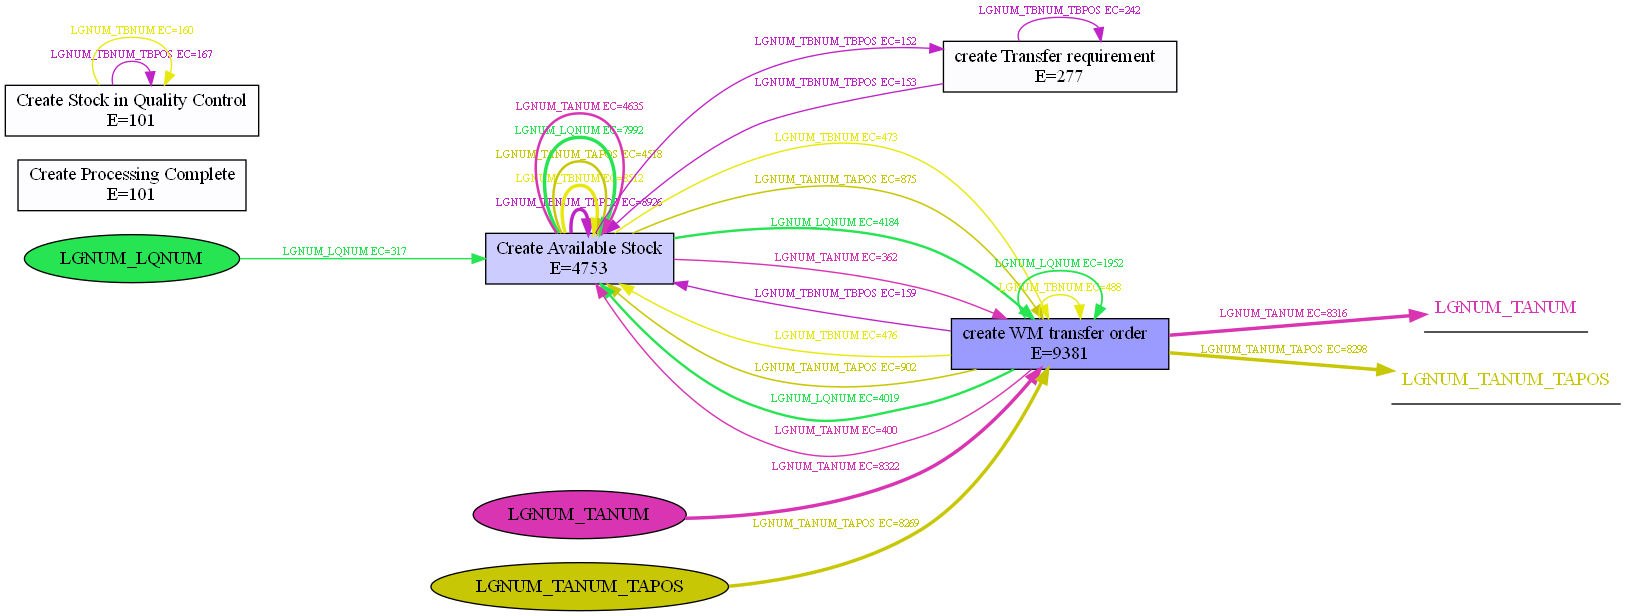

In [33]:
pm4py.view_ocdfg(ocdfg, format="png",  act_threshold = 100, edge_threshold= 150)

In [35]:
pm4py.vis.save_vis_ocdfg(ocdfg,'WM_Fianl.svg' ,act_threshold = 100, edge_threshold= 150 )

In [36]:
print(pm4py.llm.abstract_ocel_ocdfg(ocel_pm4py))


If I have an object-centric event log with the following directly follows graph (split between the different object types):

Object type: LGNUM_TBNUM_TBPOS
  "Create Available Stock" -> "Create Available Stock" (frequency (number of events) = 8926, frequency (number of objects) = 340, duration = 149485.17)
  "create Transfer requirement  " -> "create Transfer requirement  " (frequency (number of events) = 242, frequency (number of objects) = 229, duration = 75888.44)
  "Create Stock in Quality Control" -> "Create Stock in Quality Control" (frequency (number of events) = 167, frequency (number of objects) = 230, duration = 10875.36)
  "create WM transfer order  " -> "Create Available Stock" (frequency (number of events) = 159, frequency (number of objects) = 195, duration = 3905223.16)
  "create Transfer requirement  " -> "Create Available Stock" (frequency (number of events) = 153, frequency (number of objects) = 264, duration = 2655587.07)
  "Create Available Stock" -> "create Transf